In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
from adjustText import adjust_text
from IPython.display import display

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/plots is missing, it will be created; if it already exists, nothing happens
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def _safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def _unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = _safe_filename(title) or "plot"
        filename = filename + ".png"

    path = _unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def _get_current_plot_title() -> str:
    fig = plt.gcf()

    # Trying suptitle first
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def _autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = _get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        _autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")


Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
def load_csv(name: str):
    path = os.path.join(RESULTS_DIR, name)
    if not os.path.exists(path):
        print("Missing:", path)
        return None
    return pd.read_csv(path)

def show_head(df, title, n=5):
    print(f"\n--- {title} ---")
    if df is None:
        print("None")
        return
    display(df.head(n))
    print(f"rows={len(df)} cols={len(df.columns)}")

def bar_plot(df, x_col, y_col, title, rotate=30):

    # Generic bar-plot helper used throughout the notebook for comparing models/metrics
    # x_col is typically "model", y_col is typically "accuracy" or a fairness metric column
    if df is None or len(df) == 0:
        print("Nothing to plot:", title)
        return
    
    # Working on a copy to avoid mutating the original DataFrame outside this function
    d = df.copy()
    plt.figure()
    plt.bar(d[x_col].astype(str), d[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=rotate, ha="right")
    plt.show()

def scatter_plot(df, x_col, y_col, label_col, title, label_prefix=""):

    # Generic scatter-plot helper, mainly used to visualize trade-offs (e.g., accuracy vs fairness)
    # label_col is used to annotate points (e.g., model name or eps setting)
    if df is None or len(df) == 0:
        print("Nothing to plot:", title)
        return
    plt.figure()
    plt.scatter(df[x_col], df[y_col])
    for _, r in df.iterrows():
        plt.text(r[x_col], r[y_col], f"{label_prefix}{r[label_col]}", fontsize=8)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


In [4]:
# Loading all result CSVs produced by earlier notebooks/experiments so we can:
#   1) quickly inspect them (sanity check),
#   2) generate final plots in one central place,
#   3) avoid re-running expensive training steps again

# Baseline fairness summary tables
adult_base_sex = load_csv("adult_baseline_fairness_sex.csv")
german_base_pss = load_csv("german_baseline_fairness_sex.csv")

# Optional baselines 
adult_base_race = load_csv("adult_baseline_fairness_race.csv")

# DP mitigation sweep (Logistic Regression using ExponentiatedGradient)
adult_dp_sweep = load_csv("adult_logreg_dp_sweep.csv")
german_dp_sweep = load_csv("german_logreg_dp_sweep.csv")

# ThresholdOptimizer compare (baseline vs equalized_odds thresholding and optionally dp thresholding)
adult_thresh_compare = load_csv("adult_logreg_threshold_compare.csv")
german_thresh_compare = load_csv("german_logreg_threshold_compare.csv")

# calibration results (Brier score overall and by-group gap)
adult_calib_sex = load_csv("adult_baseline_calibration_sex.csv")
german_calib_pss = load_csv("german_baseline_calibration_sex.csv")

show_head(adult_base_sex, "Adult baseline fairness (sex)")
show_head(german_base_pss, "German baseline fairness (sex)")
show_head(adult_dp_sweep, "Adult DP sweep (ExponentiatedGradient + DP)")
show_head(german_dp_sweep, "German DP sweep (ExponentiatedGradient + DP)")
show_head(adult_thresh_compare, "Adult ThresholdOptimizer compare")
show_head(german_thresh_compare, "German ThresholdOptimizer compare")



--- Adult baseline fairness (sex) ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,dummy,0.754316,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
1,adult_income,logreg,0.848207,0.733487,0.600270,0.660226,0.173951,0.325275,0.057805,0.076124,0.066965,0.013494
2,adult_income,tree,0.806707,0.605004,0.614324,0.609629,0.179032,0.418489,0.048988,0.094963,0.071975,0.121531
3,adult_income,rf,0.847410,0.722398,0.615405,0.664623,0.179827,0.328904,0.069282,0.079130,0.074206,0.007492
4,adult_income,gb,0.865870,0.794737,0.612162,0.691603,0.164263,0.323547,0.057010,0.056715,0.056863,0.021670


rows=5 cols=12

--- German baseline fairness (sex) ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,german_credit,dummy,0.700,0.700000,1.000000,0.823529,0.000000,1.000000,0.000,0.000,0.0000,0.047619
1,german_credit,logreg,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.0500,0.069986
2,german_credit,tree,0.675,0.758621,0.785714,0.771930,0.130952,0.828660,0.155,0.050,0.1025,0.065175
3,german_credit,rf,0.725,0.763975,0.878571,0.817276,0.007143,0.991150,0.005,0.025,0.0150,0.049594
4,german_credit,gb,0.750,0.796053,0.864286,0.828767,0.061905,0.920489,0.090,0.050,0.0700,0.072328


rows=5 cols=12

--- Adult DP sweep (ExponentiatedGradient + DP) ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,logreg_fair_dp_eps0.005,0.828287,0.725689,0.484054,0.580739,0.010915,0.934811,0.264995,0.042598,0.153796,0.308006
1,adult_income,logreg_fair_dp_eps0.01,0.827756,0.724614,0.482162,0.579033,0.013043,0.922242,0.260881,0.040221,0.150551,0.302072
2,adult_income,logreg_fair_dp_eps0.02,0.826760,0.720761,0.481351,0.577216,0.013325,0.920882,0.266063,0.038507,0.152285,0.294525
3,adult_income,logreg_fair_dp_eps0.05,0.827623,0.722760,0.484054,0.579799,0.014619,0.913653,0.260768,0.038563,0.149665,0.296632


rows=4 cols=12

--- German DP sweep (ExponentiatedGradient + DP) ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,german_credit,logreg_fair_dp_eps0.005,0.715,0.790210,0.807143,0.798587,0.026190,0.964286,0.025,0.075,0.050,0.058081
1,german_credit,logreg_fair_dp_eps0.01,0.710,0.788732,0.800000,0.794326,0.014286,0.980000,0.035,0.075,0.055,0.071905
2,german_credit,logreg_fair_dp_eps0.02,0.695,0.780142,0.785714,0.782918,0.016667,0.976744,0.015,0.125,0.070,0.085192
3,german_credit,logreg_fair_dp_eps0.05,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.050,0.069986


rows=4 cols=12

--- Adult ThresholdOptimizer compare ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,logreg_baseline,0.848207,0.733487,0.600270,0.660226,0.173951,0.325275,0.057805,0.076124,0.066965,0.013494
1,adult_income,logreg_thresh_equalized_odds,0.830876,0.697229,0.550811,0.615431,0.101372,0.553743,0.008035,0.009068,0.008551,0.262420
2,adult_income,logreg_thresh_demographic_parity,0.823838,0.685704,0.522432,0.593036,0.004339,0.977178,0.312809,0.057811,0.185310,0.322552


rows=3 cols=12

--- German ThresholdOptimizer compare ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,german_credit,logreg_baseline,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.0500,0.069986
1,german_credit,logreg_thresh_equalized_odds,0.750,0.821429,0.821429,0.821429,0.023810,0.966330,0.100,0.200,0.1500,0.126879
2,german_credit,logreg_thresh_demographic_parity,0.735,0.827068,0.785714,0.805861,0.002381,0.996429,0.085,0.250,0.1675,0.145968


rows=3 cols=12


In [5]:
# Trying to load already-combined "all experiments" tables (if they were created in a previous run)
# These combined tables make it easier to do final comparisons/plots across baselines + mitigations
# without manually merging multiple CSVs each time
adult_all = load_csv("adult_all_experiments_combined.csv")
german_all = load_csv("german_all_experiments_combined.csv")

def combine_parts(parts):
    # Helper to concatenate multiple experiment DataFrames into one table
    # It filters out None/empty inputs so the notebook still works if some experiments were skipped
    parts = [p for p in parts if p is not None and len(p) > 0]
    if not parts:
        return None
    return pd.concat(parts, ignore_index=True)

# If the combined Adult table doesn't exist yet, build it from the pieces we loaded above
if adult_all is None:
    adult_all = combine_parts([
        # Baseline model results (multiple models)
        adult_base_sex.assign(experiment="baseline_models") if adult_base_sex is not None else None,
        # ExponentiatedGradient + DemographicParity sweep (different eps settings)
        adult_dp_sweep.assign(experiment="mitigation_dp_sweep") if adult_dp_sweep is not None else None,
        # ThresholdOptimizer results (baseline vs EO/DP thresholding)
        adult_thresh_compare.assign(experiment="mitigation_threshold") if adult_thresh_compare is not None else None,
    ])
    # Saving the combined table
    if adult_all is not None:
        adult_all.to_csv(os.path.join(RESULTS_DIR, "adult_all_experiments_combined.csv"), index=False)
        print("Saved: results/adult_all_experiments_combined.csv")

# Same logic for the German Credit dataset
if german_all is None:
    german_all = combine_parts([
        german_base_pss.assign(experiment="baseline_models") if german_base_pss is not None else None,
        german_dp_sweep.assign(experiment="mitigation_dp_sweep") if german_dp_sweep is not None else None,
        german_thresh_compare.assign(experiment="mitigation_threshold") if german_thresh_compare is not None else None,
    ])
    if german_all is not None:
        german_all.to_csv(os.path.join(RESULTS_DIR, "german_all_experiments_combined.csv"), index=False)
        print("Saved: results/german_all_experiments_combined.csv")

show_head(adult_all, "Adult ALL combined")
show_head(german_all, "German ALL combined")

Missing: results\adult_all_experiments_combined.csv
Missing: results\german_all_experiments_combined.csv
Saved: results/adult_all_experiments_combined.csv
Saved: results/german_all_experiments_combined.csv

--- Adult ALL combined ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff,experiment
0,adult_income,dummy,0.754316,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,baseline_models
1,adult_income,logreg,0.848207,0.733487,0.600270,0.660226,0.173951,0.325275,0.057805,0.076124,0.066965,0.013494,baseline_models
2,adult_income,tree,0.806707,0.605004,0.614324,0.609629,0.179032,0.418489,0.048988,0.094963,0.071975,0.121531,baseline_models
3,adult_income,rf,0.847410,0.722398,0.615405,0.664623,0.179827,0.328904,0.069282,0.079130,0.074206,0.007492,baseline_models
4,adult_income,gb,0.865870,0.794737,0.612162,0.691603,0.164263,0.323547,0.057010,0.056715,0.056863,0.021670,baseline_models


rows=12 cols=13

--- German ALL combined ---


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff,experiment
0,german_credit,dummy,0.700,0.700000,1.000000,0.823529,0.000000,1.000000,0.000,0.000,0.0000,0.047619,baseline_models
1,german_credit,logreg,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.0500,0.069986,baseline_models
2,german_credit,tree,0.675,0.758621,0.785714,0.771930,0.130952,0.828660,0.155,0.050,0.1025,0.065175,baseline_models
3,german_credit,rf,0.725,0.763975,0.878571,0.817276,0.007143,0.991150,0.005,0.025,0.0150,0.049594,baseline_models
4,german_credit,gb,0.750,0.796053,0.864286,0.828767,0.061905,0.920489,0.090,0.050,0.0700,0.072328,baseline_models


rows=12 cols=13


Saved plot: results/plots/adult_sex_baseline_accuracy_by_model.png


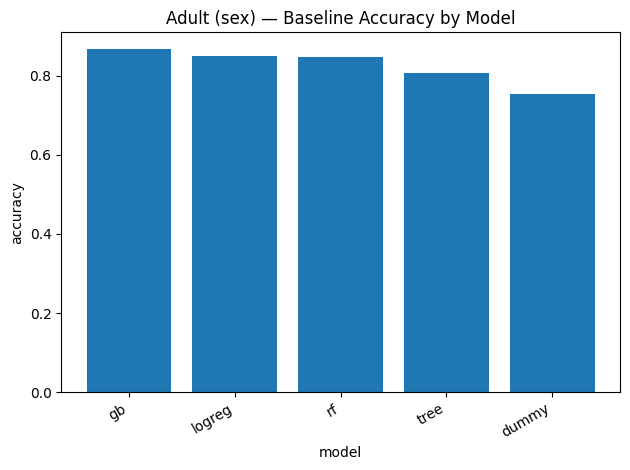

Saved plot: results/plots/adult_sex_baseline_spd_by_model.png


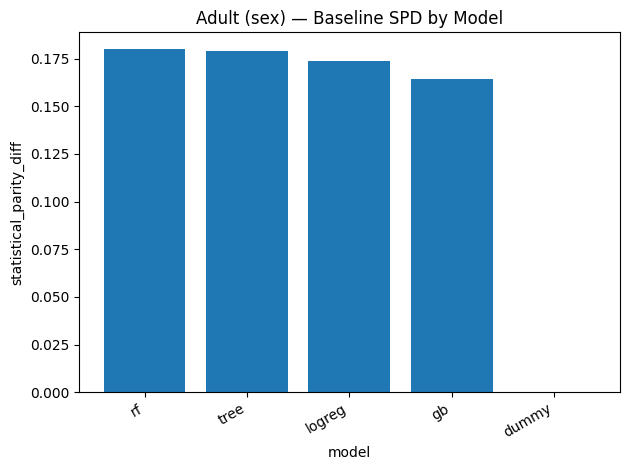

Saved plot: results/plots/adult_sex_baseline_eod_by_model.png


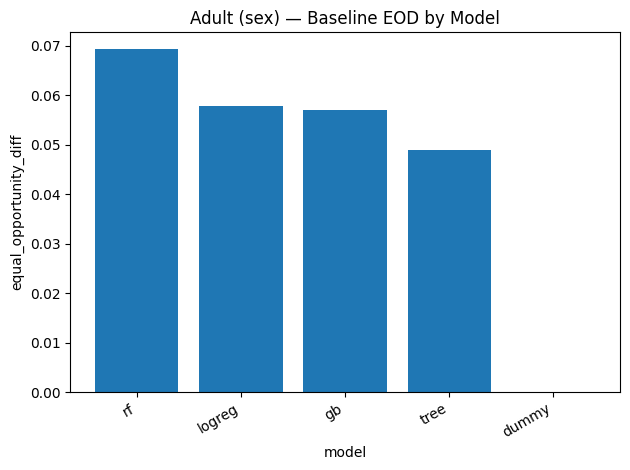

Saved plot: results/plots/adult_sex_baselines_accuracy_vs_spd.png


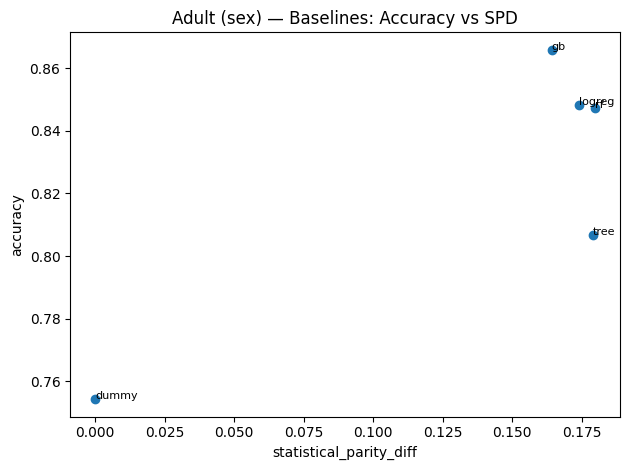

Saved plot: results/plots/german_baseline_accuracy_by_model.png


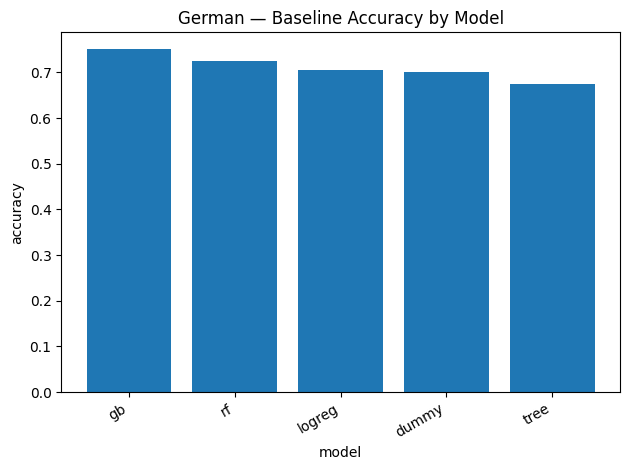

Saved plot: results/plots/german_baseline_spd_by_model.png


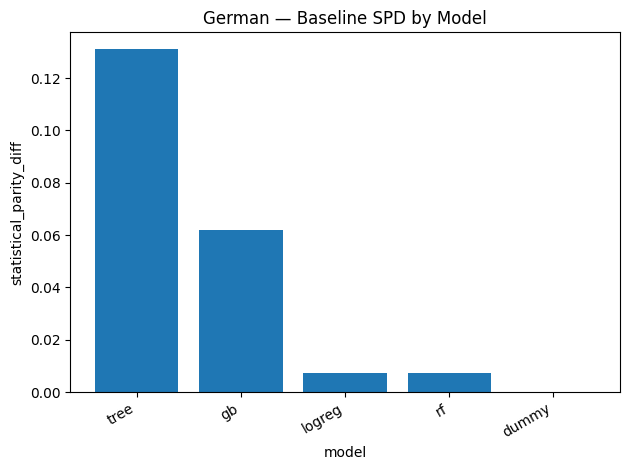

Saved plot: results/plots/german_baseline_eod_by_model.png


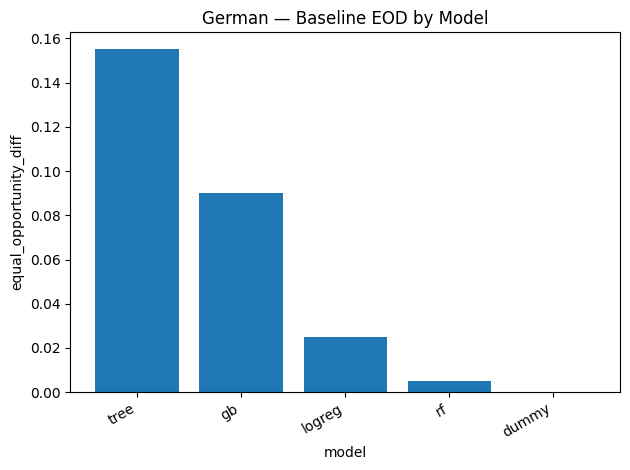

Saved plot: results/plots/german_baselines_accuracy_vs_spd.png


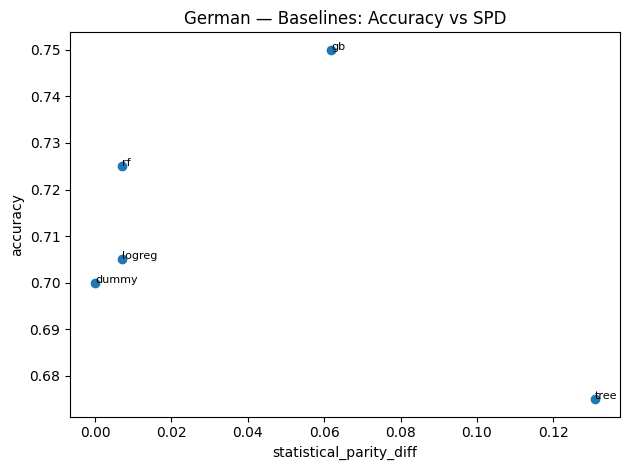

In [6]:
# Creating baseline comparison plots for Adult Income (protected attribute = sex):
#   - Accuracy by model (bar chart)
#   - Statistical Parity Difference (SPD) by model (bar chart)
#   - Equal Opportunity Difference (EOD) by model (bar chart)
#   - Trade-off scatter: Accuracy vs SPD (each point = one baseline model)
if adult_base_sex is not None:
    bar_plot(adult_base_sex.sort_values("accuracy", ascending=False), "model", "accuracy",
             "Adult (sex) — Baseline Accuracy by Model")
    bar_plot(adult_base_sex.sort_values("statistical_parity_diff", ascending=False), "model", "statistical_parity_diff",
             "Adult (sex) — Baseline SPD by Model")
    bar_plot(adult_base_sex.sort_values("equal_opportunity_diff", ascending=False), "model", "equal_opportunity_diff",
             "Adult (sex) — Baseline EOD by Model")
    scatter_plot(adult_base_sex, "statistical_parity_diff", "accuracy", "model",
                 "Adult (sex) — Baselines: Accuracy vs SPD")

# Creating baseline comparison plots for German Credit (protected attribute = sex)
# Same structure as Adult:
#   - Accuracy, SPD, and EOD bar charts
#   - Trade-off scatter: Accuracy vs SPD
if german_base_pss is not None:
    bar_plot(german_base_pss.sort_values("accuracy", ascending=False), "model", "accuracy",
             "German — Baseline Accuracy by Model")
    bar_plot(german_base_pss.sort_values("statistical_parity_diff", ascending=False), "model", "statistical_parity_diff",
             "German — Baseline SPD by Model")
    bar_plot(german_base_pss.sort_values("equal_opportunity_diff", ascending=False), "model", "equal_opportunity_diff",
             "German — Baseline EOD by Model")
    scatter_plot(german_base_pss, "statistical_parity_diff", "accuracy", "model",
                 "German — Baselines: Accuracy vs SPD")


Saved plot: results/plots/adult_sex_calibration_disparity_brier_diff.png


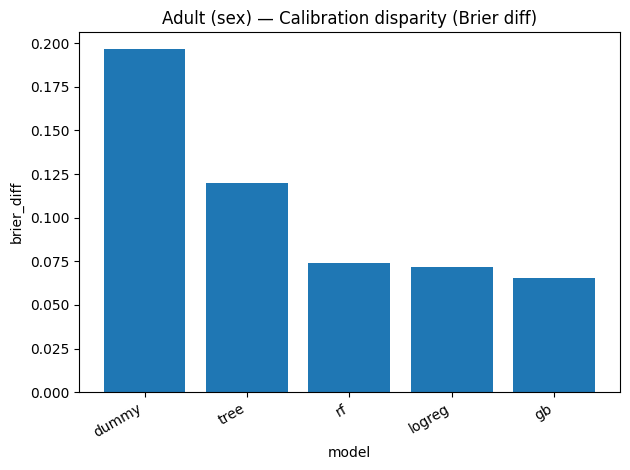

Saved plot: results/plots/german_calibration_disparity_brier_diff.png


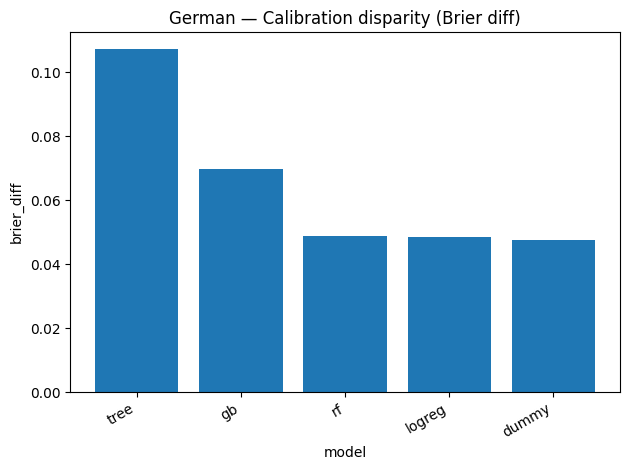

In [7]:
# Plotting calibration-within-groups disparities using the Brier score gap (max group - min group)
# "brier_diff" summarizes how uneven calibration is across protected groups:
#   - lower brier_diff => more similar calibration across groups (better group fairness in calibration)
#   - higher brier_diff => larger calibration disparity between groups

# Adult Income: only plot if the calibration table exists and contains the expected column
if adult_calib_sex is not None and "brier_diff" in adult_calib_sex.columns:
    bar_plot(adult_calib_sex.sort_values("brier_diff", ascending=False), "model", "brier_diff",
             "Adult (sex) — Calibration disparity (Brier diff)")
    
# German Credit: same logic for the protected attribute sex
if german_calib_pss is not None and "brier_diff" in german_calib_pss.columns:
    bar_plot(german_calib_pss.sort_values("brier_diff", ascending=False), "model", "brier_diff",
             "German — Calibration disparity (Brier diff)")


In [8]:
def pareto_front(df, maximize_col, minimize_cols):
    """
    Computing a simple Pareto front (non-dominated set)

    A row is kept if there is NO other row that is strictly better or equal in all objectives:
      - MAXIMIZE `maximize_col` (e.g., accuracy)
      - MINIMIZE all `minimize_cols` (e.g., fairness gaps like SPD/EOD)

    A point j *dominates* point i if:
      - maximize_col(j) >= maximize_col(i)  AND
      - minimize_cols(j) <= minimize_cols(i) for all minimize cols  AND
      - at least one of these comparisons is strict (better in at least one dimension)

    Returns:
        a DataFrame containing only the non-dominated rows
    """
    df = df.copy().reset_index(drop=True)
    keep = np.ones(len(df), dtype=bool)

    # Converting the objective columns into a NumPy array for faster comparisons
    # Column 0 = maximize objective; columns 1.. = minimize objectives
    vals = df[[maximize_col] + minimize_cols].to_numpy()

    for i in range(len(df)):
        if not keep[i]:
            continue
        ai = vals[i, 0] # value of maximize objective for row i
        mi = vals[i, 1:] # values of minimize objectives for row i

        # Comparing row i against every other row j
        for j in range(len(df)):
            if i == j or not keep[i]:
                continue
            aj = vals[j, 0]
            mj = vals[j, 1:]
            # j dominates i if: aj >= ai AND mj <= mi AND at least one strict
            if (aj >= ai) and np.all(mj <= mi) and ((aj > ai) or np.any(mj < mi)):
                keep[i] = False
    return df[keep].copy()

def thesis_summary(df, dataset_label, alpha=0.5):
    """
    Creating a compact, thesis-friendly summary of "best" models under different criteria,
    plus a Pareto front for accuracy vs fairness

    alpha controls the weight of fairness in a simple composite score:
      tradeoff_score = accuracy - alpha * mean(SPD, EOD)

    Inputs:
        df: DataFrame with experiment results (one row per model/setting)
        dataset_label: string used in output tables (e.g., "adult_income")
        alpha: penalty strength for fairness gaps in the composite tradeoff score

    Outputs:
        summary: DataFrame with "best picks" for different criteria
        pareto: DataFrame containing the Pareto front (accuracy vs SPD/EOD)
    """
    if df is None or len(df) == 0:
        return None, None
    
    # Ensuring the metrics we need exist (this prevents cryptic errors later)
    required = ["accuracy", "statistical_parity_diff", "equal_opportunity_diff",
                "disparate_impact_ratio", "predictive_parity_diff", "model"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{dataset_label}: missing columns: {missing}")

    d = df.copy()

    # DI: "best" is closest to 1
    # Disparate impact ratio (DI): ideal is 1.0, so we measure "gap to 1"
    # Smaller di_gap means DI is closer to parity
    d["di_gap"] = (d["disparate_impact_ratio"] - 1.0).abs()

    # Best single-criterion picks
    # Pick "best" rows by single criteria:
    # - best accuracy (max)
    # - fairest under SPD/EOD/PPD (min)
    # - closest DI to 1 (min di_gap)
    best_acc = d.loc[d["accuracy"].idxmax()]
    best_spd = d.loc[d["statistical_parity_diff"].idxmin()]
    best_eod = d.loc[d["equal_opportunity_diff"].idxmin()]
    best_di  = d.loc[d["di_gap"].idxmin()]
    best_pp  = d.loc[d["predictive_parity_diff"].idxmin()]

    # Best trade-off (simple composite)
    # Simple composite fairness penalty (average of SPD and EOD)
    d["fairness_penalty"] = (d["statistical_parity_diff"] + d["equal_opportunity_diff"]) / 2.0

    # Trade-off score: accuracy minus fairness penalty (weighted by alpha)
    # Higher tradeoff_score is interpreted as "better overall compromise"
    d["tradeoff_score"] = d["accuracy"] - alpha * d["fairness_penalty"]
    best_trade = d.loc[d["tradeoff_score"].idxmax()]

    # Computing Pareto front focusing on the most central trade-off:
    # maximizing accuracy, minimizing SPD and EOD
    pareto = pareto_front(
        d.dropna(subset=["accuracy", "statistical_parity_diff", "equal_opportunity_diff"]),
        maximize_col="accuracy",
        minimize_cols=["statistical_parity_diff", "equal_opportunity_diff"],
    ).sort_values("accuracy", ascending=False)

    # Helper to convert a picked row into a clean, consistent summary dict
    def row(pick_name, r):
        return {
            "dataset": dataset_label,
            "pick": pick_name,
            # "experiment" is optional (e.g., baseline_models / mitigation_dp_sweep / mitigation_threshold)
            "experiment": r.get("experiment", ""),
            "model": r["model"],
            "accuracy": float(r["accuracy"]),
            "SPD": float(r["statistical_parity_diff"]),
            "EOD": float(r["equal_opportunity_diff"]),
            "DI": float(r["disparate_impact_ratio"]),
            "PPD": float(r["predictive_parity_diff"]),
        }
    
    # Building the summary table
    summary = pd.DataFrame([
        row("Best accuracy", best_acc),
        row("Fairest (min SPD)", best_spd),
        row("Fairest (min EOD)", best_eod),
        row("Closest DI to 1", best_di),
        row("Fairest (min PPD)", best_pp),
        row(f"Best trade-off (alpha={alpha})", best_trade),
    ])

    return summary, pareto

# Running the summary + Pareto analysis for both datasets if the combined tables exist
adult_summary, adult_pareto = thesis_summary(adult_all, "adult_income", alpha=0.5) if adult_all is not None else (None, None)
german_summary, german_pareto = thesis_summary(german_all, "german_credit", alpha=0.5) if german_all is not None else (None, None)

print("=== Thesis Summary Picks ===")
if adult_summary is not None:
    display(adult_summary)
if german_summary is not None:
    display(german_summary)

# Showing Pareto front tables (only key columns) so you can quickly see the non-dominated candidates
print("=== Pareto Front (Adult) ===")
if adult_pareto is not None:
    display(adult_pareto[["experiment","model","accuracy","statistical_parity_diff","equal_opportunity_diff","disparate_impact_ratio","predictive_parity_diff"]])

print("=== Pareto Front (German) ===")
if german_pareto is not None:
    display(german_pareto[["experiment","model","accuracy","statistical_parity_diff","equal_opportunity_diff","disparate_impact_ratio","predictive_parity_diff"]])

# Saving outputs 
if adult_summary is not None:
    adult_summary.to_csv(os.path.join(RESULTS_DIR, "adult_thesis_summary_picks.csv"), index=False)
if german_summary is not None:
    german_summary.to_csv(os.path.join(RESULTS_DIR, "german_thesis_summary_picks.csv"), index=False)
if adult_pareto is not None:
    adult_pareto.to_csv(os.path.join(RESULTS_DIR, "adult_pareto_front.csv"), index=False)
if german_pareto is not None:
    german_pareto.to_csv(os.path.join(RESULTS_DIR, "german_pareto_front.csv"), index=False)

print("Saved:")
print("- results/adult_thesis_summary_picks.csv")
print("- results/german_thesis_summary_picks.csv")
print("- results/adult_pareto_front.csv")
print("- results/german_pareto_front.csv")

=== Thesis Summary Picks ===


,dataset,pick,experiment,model,accuracy,SPD,EOD,DI,PPD
0,adult_income,Best accuracy,baseline_models,gb,0.865870,0.164263,0.057010,0.323547,0.021670
1,adult_income,Fairest (min SPD),baseline_models,dummy,0.754316,0.000000,0.000000,NaN,0.000000
2,adult_income,Fairest (min EOD),baseline_models,dummy,0.754316,0.000000,0.000000,NaN,0.000000
3,adult_income,Closest DI to 1,mitigation_threshold,logreg_thresh_demographic_parity,0.823838,0.004339,0.312809,0.977178,0.322552
4,adult_income,Fairest (min PPD),baseline_models,dummy,0.754316,0.000000,0.000000,NaN,0.000000
5,adult_income,Best trade-off (alpha=0.5),baseline_models,gb,0.865870,0.164263,0.057010,0.323547,0.021670


,dataset,pick,experiment,model,accuracy,SPD,EOD,DI,PPD
0,german_credit,Best accuracy,baseline_models,gb,0.750,0.061905,0.090,0.920489,0.072328
1,german_credit,Fairest (min SPD),baseline_models,dummy,0.700,0.000000,0.000,1.000000,0.047619
2,german_credit,Fairest (min EOD),baseline_models,dummy,0.700,0.000000,0.000,1.000000,0.047619
3,german_credit,Closest DI to 1,baseline_models,dummy,0.700,0.000000,0.000,1.000000,0.047619
4,german_credit,Fairest (min PPD),baseline_models,dummy,0.700,0.000000,0.000,1.000000,0.047619
5,german_credit,Best trade-off (alpha=0.5),baseline_models,rf,0.725,0.007143,0.005,0.991150,0.049594


=== Pareto Front (Adult) ===


,experiment,model,accuracy,statistical_parity_diff,equal_opportunity_diff,disparate_impact_ratio,predictive_parity_diff
4,baseline_models,gb,0.865870,0.164263,0.057010,0.323547,0.021670
10,mitigation_threshold,logreg_thresh_equalized_odds,0.830876,0.101372,0.008035,0.553743,0.262420
5,mitigation_dp_sweep,logreg_fair_dp_eps0.005,0.828287,0.010915,0.264995,0.934811,0.308006
6,mitigation_dp_sweep,logreg_fair_dp_eps0.01,0.827756,0.013043,0.260881,0.922242,0.302072
8,mitigation_dp_sweep,logreg_fair_dp_eps0.05,0.827623,0.014619,0.260768,0.913653,0.296632
11,mitigation_threshold,logreg_thresh_demographic_parity,0.823838,0.004339,0.312809,0.977178,0.322552
0,baseline_models,dummy,0.754316,0.000000,0.000000,NaN,0.000000


=== Pareto Front (German) ===


,experiment,model,accuracy,statistical_parity_diff,equal_opportunity_diff,disparate_impact_ratio,predictive_parity_diff
4,baseline_models,gb,0.750,0.061905,0.090,0.920489,0.072328
10,mitigation_threshold,logreg_thresh_equalized_odds,0.750,0.023810,0.100,0.966330,0.126879
11,mitigation_threshold,logreg_thresh_demographic_parity,0.735,0.002381,0.085,0.996429,0.145968
3,baseline_models,rf,0.725,0.007143,0.005,0.991150,0.049594
0,baseline_models,dummy,0.700,0.000000,0.000,1.000000,0.047619


Saved:
- results/adult_thesis_summary_picks.csv
- results/german_thesis_summary_picks.csv
- results/adult_pareto_front.csv
- results/german_pareto_front.csv


Saved plot: results/plots/adult_income_accuracy_vs_spd_all_experiments.png


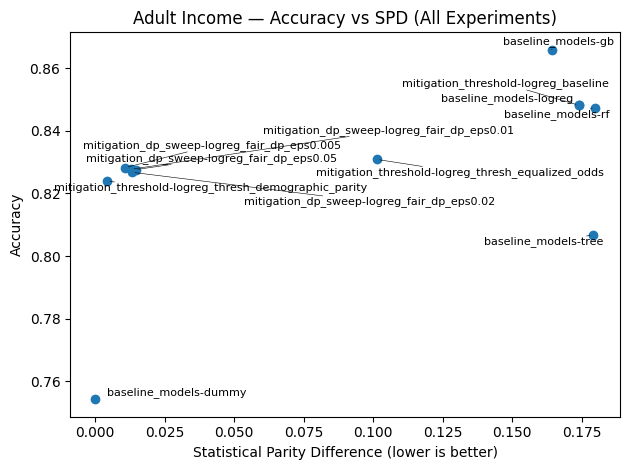

Saved plot: results/plots/german_credit_accuracy_vs_spd_all_experiments.png


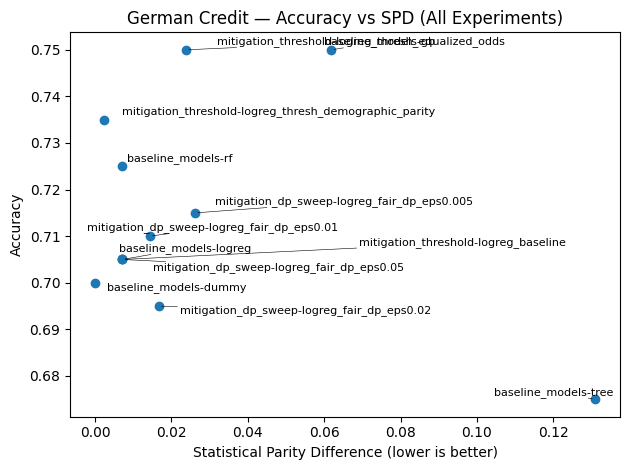

Saved plot: results/plots/adult_income_accuracy_vs_spd_pareto.png


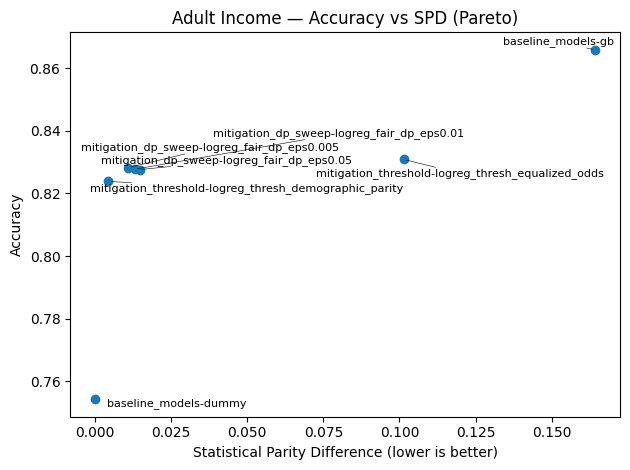

Saved plot: results/plots/german_credit_accuracy_vs_spd_pareto.png


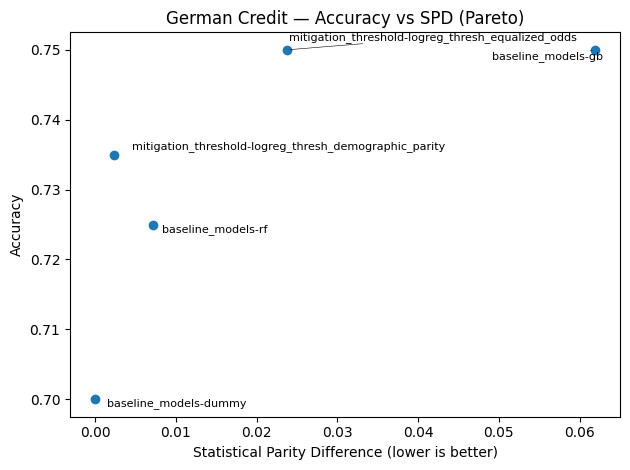

In [9]:
def plot_tradeoff_with_pareto(df, pareto_df, title, label_all=True):
    """
    Plotting Accuracy vs SPD and label points.
    """
    if df is None or len(df) == 0:
        print("Nothing to plot:", title)
        return

    d = df.copy()

    fig, ax = plt.subplots()
    ax.scatter(d["statistical_parity_diff"], d["accuracy"])

    # Helper to build compact labels
    def make_label(r, prefix=""):
        exp = r.get("experiment", "")
        base = f"{exp}-{r['model']}" if ("experiment" in d.columns and exp) else str(r["model"])
        return f"{prefix}{base}"

    texts = []

    # Labelling ALL points (label_all=True)
    if label_all:
        for _, r in d.iterrows():
            t = ax.text(
                r["statistical_parity_diff"],
                r["accuracy"],
                make_label(r),
                fontsize=8,
            )
            texts.append(t)

    # Overlaying Pareto points with a distinct marker
    if pareto_df is not None and len(pareto_df) > 0:
        ax.scatter(pareto_df["statistical_parity_diff"], pareto_df["accuracy"], marker="x")
        for _, r in pareto_df.iterrows():
            t = ax.text(
                r["statistical_parity_diff"],
                r["accuracy"],
                make_label(r, prefix="P:"),
                fontsize=9,
            )
            texts.append(t)

    # Automatically moving labels to reduce overlaps
    if len(texts) > 0:
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(arrowstyle="-", lw=0.4),
        )

    ax.set_title(title)
    ax.set_xlabel("Statistical Parity Difference (lower is better)")
    ax.set_ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

#Initially combined pareto and all experiments, but seperated because of readabilty
plot_tradeoff_with_pareto(adult_all,"", "Adult Income — Accuracy vs SPD (All Experiments)", label_all=True)
plot_tradeoff_with_pareto(german_all,"","German Credit — Accuracy vs SPD (All Experiments)", label_all=True)

plot_tradeoff_with_pareto(adult_pareto,"", "Adult Income — Accuracy vs SPD (Pareto)", label_all=True)
plot_tradeoff_with_pareto(german_pareto,"", "German Credit — Accuracy vs SPD (Pareto)", label_all=True)